In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import stats

from sklearn.model_selection import train_test_split,KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.metrics import roc_auc_score,confusion_matrix, f1_score
from sklearn.preprocessing import label_binarize

In [2]:
# Reading the data
df= pd.read_csv('./data/electricalfault.csv')
dfc =pd.read_csv('./data/classfault.csv')

In [3]:
df.head()

,Output (S),Ia,Ib,Ic,Va,Vb,Vc,Unnamed: 7,Unnamed: 8
0,0,-170.472196,9.219613,161.252583,0.054490,-0.659921,0.605431,NaN,NaN
1,0,-122.235754,6.168667,116.067087,0.102000,-0.628612,0.526202,NaN,NaN
2,0,-90.161474,3.813632,86.347841,0.141026,-0.605277,0.464251,NaN,NaN
3,0,-79.904916,2.398803,77.506112,0.156272,-0.602235,0.445963,NaN,NaN
4,0,-63.885255,0.590667,63.294587,0.180451,-0.591501,0.411050,NaN,NaN


In [4]:
df =df.rename(columns={'Output (S)' :'Fault'})
df.drop(df.iloc[:,7:], axis=1, inplace=True)

In [5]:
df.describe()

,Fault,Ia,Ib,Ic,Va,Vb,Vc
count,12001.000000,12001.000000,12001.000000,12001.000000,12001.000000,12001.000000,12001.000000
mean,0.457962,6.709369,-26.557793,22.353043,0.010517,-0.015498,0.004980
std,0.498250,377.158470,357.458613,302.052809,0.346221,0.357644,0.349272
min,0.000000,-883.542316,-900.526951,-883.357762,-0.620748,-0.659921,-0.612709
25%,0.000000,-64.348986,-51.421937,-54.562257,-0.237610,-0.313721,-0.278951
50%,0.000000,-3.239788,4.711283,-0.399419,0.002465,-0.007192,0.008381
75%,1.000000,53.823453,69.637787,45.274542,0.285078,0.248681,0.289681
max,1.000000,885.738571,889.868884,901.274261,0.609864,0.627875,0.608243


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12001 entries, 0 to 12000
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Fault   12001 non-null  int64  
 1   Ia      12001 non-null  float64
 2   Ib      12001 non-null  float64
 3   Ic      12001 non-null  float64
 4   Va      12001 non-null  float64
 5   Vb      12001 non-null  float64
 6   Vc      12001 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 656.4 KB


In [7]:
df['Fault'].value_counts()

Fault
0    6505
1    5496
Name: count, dtype: int64

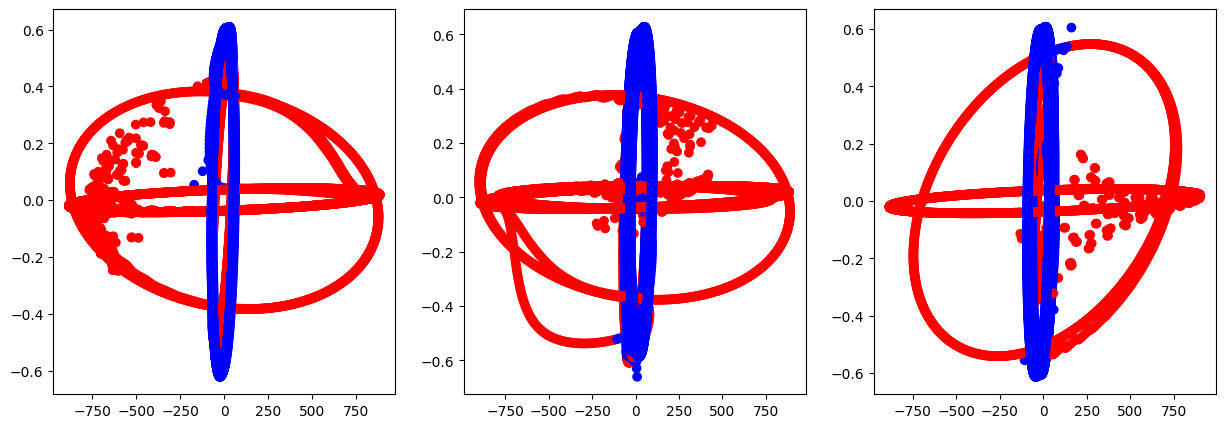

In [8]:
fig,(ax1,ax2,ax3) =plt.subplots(1,3,figsize=(15,5))
colors = {0 :'blue', 1:'red'}
ax1.scatter(df['Ia'], df['Va'], c= df['Fault'].map(colors),label=colors)
ax2.scatter(df['Ib'], df['Vb'], c= df['Fault'].map(colors),label=colors)
ax3.scatter(df['Ic'], df['Vc'], c= df['Fault'].map(colors),label=colors)
plt.show()

Based on the plot, the relationship between current and voltage per phase indicates that the there is a distinction of whether there is an 
electrical fault or not 

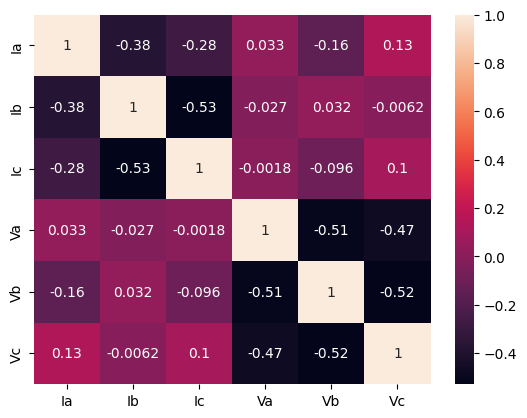

In [9]:
sns.heatmap(df.iloc[:,1:].corr(), annot=True)
plt.show()

No highly correlated independent variables found in the correlation plot

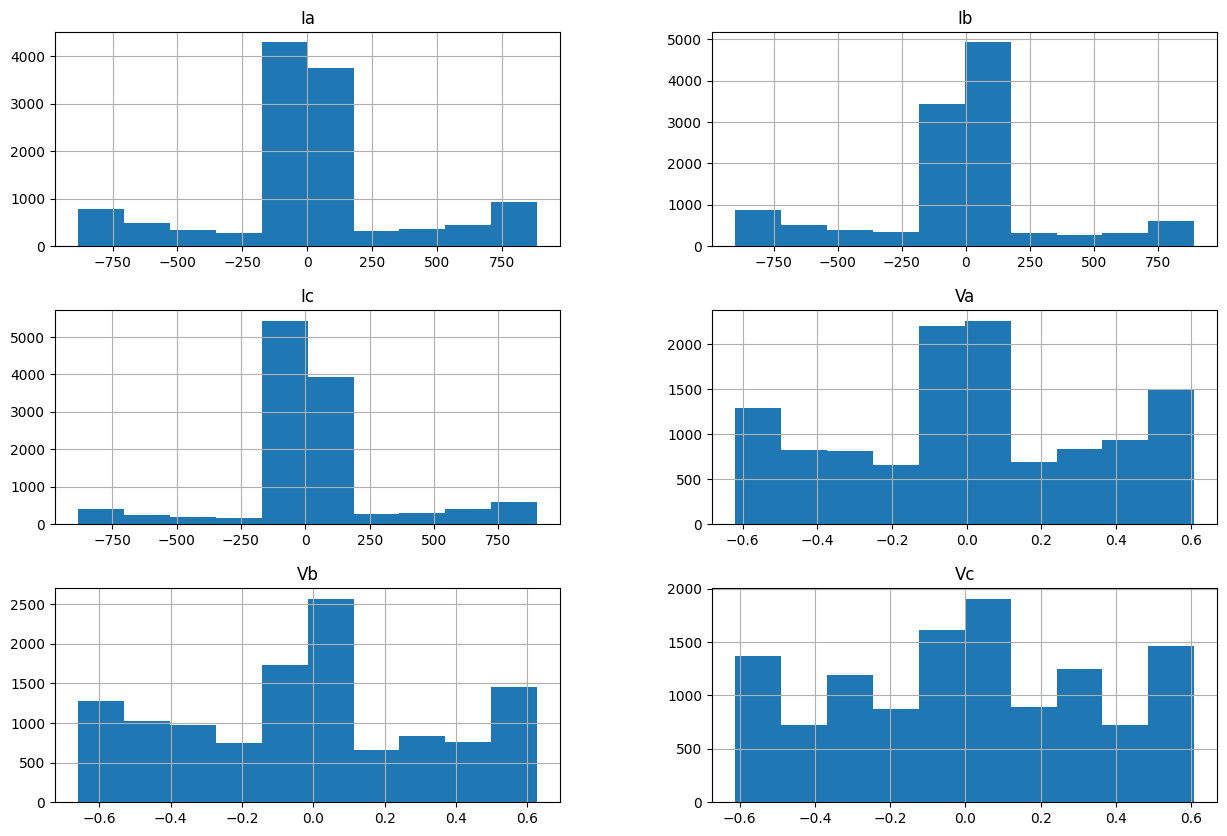

In [10]:
df.iloc[:,1:].hist(figsize=(15,10))
plt.show()

In [11]:
df =df.sample(frac=1, axis=0,random_state =42).reset_index(drop=True)
df.head(10)

,Fault,Ia,Ib,Ic,Va,Vb,Vc
0,0,-3.616198,54.901474,-54.961250,-0.593020,0.408364,0.184656
1,1,664.453661,-841.349439,-26.126327,-0.009282,-0.072336,0.081618
2,0,-2.968962,87.242288,-87.661156,-0.591300,0.469712,0.121588
3,0,49.420351,-35.350145,-11.712142,0.390757,0.205153,-0.595909
4,0,-62.474545,40.728937,21.745607,-0.229660,-0.370757,0.600417
5,1,713.660995,70.313388,-27.618649,-0.268121,0.160635,0.107486
6,0,-11.530615,-19.776581,28.110101,0.571570,-0.409146,-0.162424
7,0,49.846468,29.689117,-82.189375,-0.130802,0.595003,-0.464202
8,1,-370.802352,-526.475517,897.381725,-0.042337,0.019111,0.023226
9,1,40.100920,-764.426877,726.959325,-0.010157,0.014288,-0.004131


In [12]:
X= df.iloc[:,1:].values
y= df.iloc[:,0].values

In [13]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size =0.2, shuffle =True, random_state=42)
scores =[]
models =['Logistic','KNN','SVM','NB','Tree']

### LOGISTIC REGRESSION 

In [14]:
logistic =LogisticRegression(random_state=42)
scaler= StandardScaler()
X_train_scaled =scaler.fit_transform(X_train)
X_test_scaled =scaler.transform(X_test)
logistic.fit(X_train_scaled,y_train)
logistic.score(X_test_scaled,y_test)

0.7330279050395668

In [15]:
params ={'penalty' : ['l2'],
         'C' :np.arange(0.01,1.01,0.01),
         'solver' : ['lbfgs','liblinear']}

kf = KFold(n_splits =5, shuffle =True , random_state =42)
logistic= LogisticRegression(random_state=42)
log_clf = RandomizedSearchCV(logistic, param_distributions =params, cv=kf, n_iter=100,  random_state=42)
log_clf.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=LogisticRegression(random_state=42), n_iter=100,
                   param_distributions={'C': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39,...0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ]),
                                        'penalty': ['l2'],
                                        'solver': ['lbfgs', 'liblinear']},
                   random_state=42)

In [16]:
log_clf.best_params_

{'solver': 'liblinear', 'penalty': 'l2', 'C': 0.48000000000000004}

In [17]:
score = log_clf.score(X_test_scaled,y_test)
print(score)
scores.append(score)

0.7330279050395668


<Axes: >

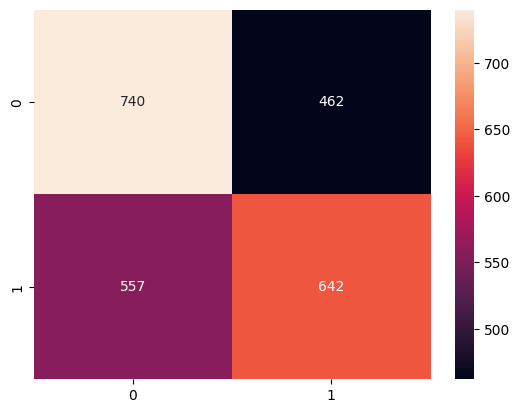

In [18]:
y_pred =log_clf.predict(X_test)
cm =confusion_matrix(y_pred,y_test)
sns.heatmap(cm, annot=True,fmt='.10g')

In [19]:
print("ROC_AUC_SCORE: ",roc_auc_score(y_pred,y_test))
print("F1_SCORE: ",f1_score(y_pred,y_test))

ROC_AUC_SCORE:  0.5755434020863198
F1_SCORE:  0.5575336517585757


### K NEAREST NEIGHBORS

In [20]:
knn =KNeighborsClassifier()
knn.fit(X_train,y_train)
knn.score(X_test,y_test)

0.9937526030820492

In [21]:
params ={ 'n_neighbors' :[3,5,7,9,11],
          'weights' :['uniform', 'distance']}

kf = KFold(n_splits =5, shuffle =True , random_state =42)

knn_clf = RandomizedSearchCV(knn, param_distributions =params, cv=kf, n_iter=10,verbose=True, random_state=42)
knn_clf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=KNeighborsClassifier(),
                   param_distributions={'n_neighbors': [3, 5, 7, 9, 11],
                                        'weights': ['uniform', 'distance']},
                   random_state=42, verbose=True)

In [22]:
knn_clf.best_params_

{'weights': 'distance', 'n_neighbors': 5}

In [23]:
knn_clf.score(X_test,y_test)

0.9962515618492295

In [24]:
score = knn_clf.score(X_test,y_test)
print(score)
scores.append(score)

0.9962515618492295


<Axes: >

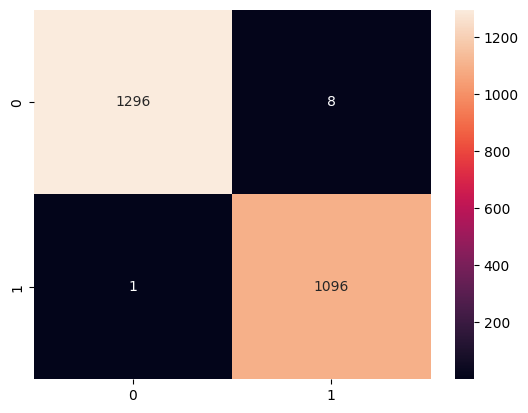

In [25]:
y_pred =knn_clf.predict(X_test)
cm =confusion_matrix(y_pred,y_test)
sns.heatmap(cm, annot=True,fmt='.10g')

In [26]:
print("ROC_AUC_SCORE: ",roc_auc_score(y_pred,y_test))
print("F1_SCORE: ",f1_score(y_pred,y_test))

ROC_AUC_SCORE:  0.9964767268232939
F1_SCORE:  0.995910949568378


### SUPPORT VECTOR MACHINES

In [27]:
svc = SVC()
svc.fit(X_train, y_train)
svc.score(X_test,y_test)

0.978758850478967

In [28]:
params ={'C':np.arange(0.01,1.01,0.01),
         'kernel' : ['rbf', 'sigmoid'],
         'gamma' : ['auto','scale']}

kf = KFold(n_splits =5, shuffle =True , random_state =42)

svc_clf = RandomizedSearchCV(svc, param_distributions =params, cv=kf, n_iter=100,verbose=True, random_state=42)
svc_clf.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=SVC(), n_iter=100,
                   param_distributions={'C': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ]),
                                        'gamma': ['auto', 'scale'],
                                        'kernel': ['rbf', 'sigmoid']},
                   random_state=42, verbose=True)

In [29]:
svc_clf.best_params_

{'kernel': 'rbf', 'gamma': 'auto', 'C': 0.19}

In [30]:
score =svc_clf.score(X_test,y_test)
print(score)
scores.append(score)

0.9795918367346939


<Axes: >

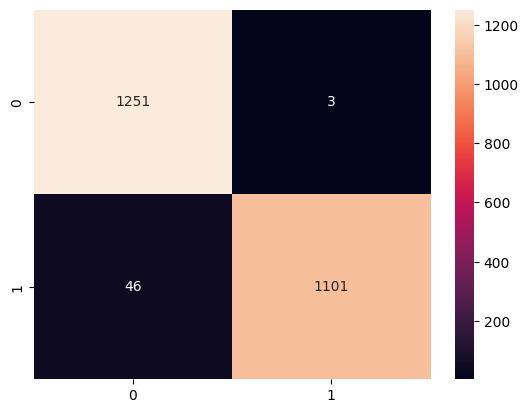

In [31]:
y_pred =svc_clf.predict(X_test)
cm =confusion_matrix(y_pred,y_test)
sns.heatmap(cm, annot=True,fmt='.10g')

In [32]:
print("ROC_AUC_SCORE: ",roc_auc_score(y_pred,y_test))
print("F1_SCORE: ",f1_score(y_pred,y_test))

ROC_AUC_SCORE:  0.9787515173763051
F1_SCORE:  0.9782318969346957


### NAIVE BAYES

In [33]:
naive =GaussianNB()
naive.fit(X_train,y_train)
score=naive.score(X_test,y_test)
print(score)
scores.append(score)

0.9783423573511038


<Axes: >

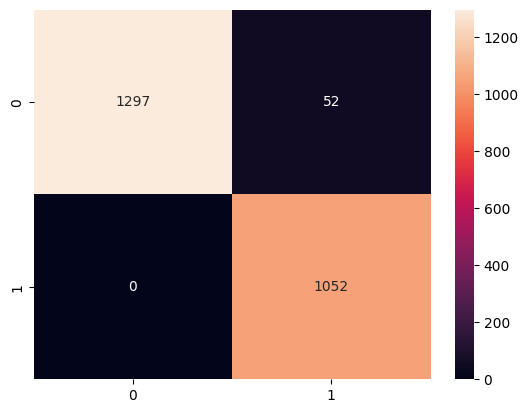

In [34]:
y_pred =naive.predict(X_test)
cm =confusion_matrix(y_pred,y_test)
sns.heatmap(cm, annot=True,fmt='.10g')

In [35]:
print("ROC_AUC_SCORE: ",roc_auc_score(y_pred,y_test))
print("F1_SCORE: ",f1_score(y_pred,y_test))

ROC_AUC_SCORE:  0.9807264640474426
F1_SCORE:  0.9758812615955473


### DECISION TREES

In [36]:
tree=DecisionTreeClassifier(random_state=42)
tree.fit(X_train,y_train)
tree.score(X_test,y_test)

0.9958350687213661

In [37]:
params ={'criterion':['gini','log_loss'],
         'max_depth' : [3,5,7,9,12],
         'min_samples_split' : [2,3,4,5,6,7,8,9]}

kf = KFold(n_splits =5, shuffle =True , random_state =42)

tree_clf = RandomizedSearchCV(tree, param_distributions =params, cv=kf, n_iter=20,verbose=True, random_state=42)
tree_clf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/home/nikki/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=DecisionTreeClassifier(random_state=42), n_iter=20,
                   param_distributions={'criterion': ['gini', 'log_loss'],
                                        'max_depth': [3, 5, 7, 9, 12],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9]},
                   random_state=42, verbose=True)

In [38]:
tree_clf.best_params_

{'min_samples_split': 3, 'max_depth': 12, 'criterion': 'log_loss'}

In [39]:
score =tree_clf.score(X_test,y_test)
print(score)
scores.append(score)

0.9925031236984589


<Axes: >

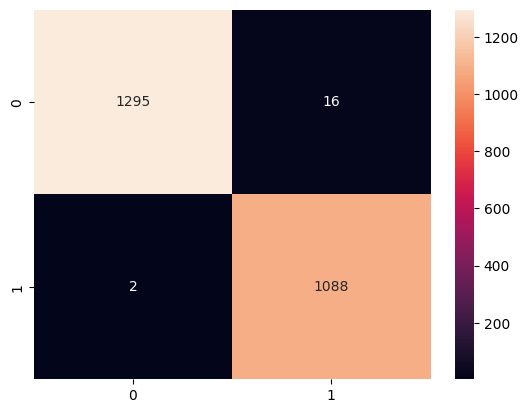

In [40]:
y_pred =tree_clf.predict(X_test)
cm =confusion_matrix(y_pred,y_test)
sns.heatmap(cm, annot=True,fmt='.10g')

In [41]:
print("ROC_AUC_SCORE: ",roc_auc_score(y_pred,y_test))
print("F1_SCORE: ",f1_score(y_pred,y_test))

ROC_AUC_SCORE:  0.9929803567554707
F1_SCORE:  0.99179580674567


Now that we have the model for classifying when there is an electrical fault, we will now use the other dataset that classify 
to which fault does it belong either on Ground, Line A, Line B , Line C or the combination of it. 


In [42]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7861 entries, 0 to 7860
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   G       7861 non-null   int64  
 1   C       7861 non-null   int64  
 2   B       7861 non-null   int64  
 3   A       7861 non-null   int64  
 4   Ia      7861 non-null   float64
 5   Ib      7861 non-null   float64
 6   Ic      7861 non-null   float64
 7   Va      7861 non-null   float64
 8   Vb      7861 non-null   float64
 9   Vc      7861 non-null   float64
dtypes: float64(6), int64(4)
memory usage: 614.3 KB


In [43]:
dfc.describe()

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc
count,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000
mean,0.432006,0.411271,0.555527,0.571429,13.721194,-44.845268,34.392394,-0.007667,0.001152,0.006515
std,0.495387,0.492095,0.496939,0.494903,464.741671,439.269195,371.107412,0.289150,0.313437,0.307897
min,0.000000,0.000000,0.000000,0.000000,-883.542316,-900.526951,-883.357762,-0.620748,-0.608016,-0.612709
25%,0.000000,0.000000,0.000000,0.000000,-119.802518,-271.845947,-61.034219,-0.130287,-0.159507,-0.215977
50%,0.000000,0.000000,1.000000,1.000000,2.042805,5.513317,-4.326711,-0.005290,0.001620,0.009281
75%,1.000000,1.000000,1.000000,1.000000,227.246377,91.194282,49.115141,0.111627,0.153507,0.239973
max,1.000000,1.000000,1.000000,1.000000,885.738571,889.868884,901.274261,0.595342,0.627875,0.600179


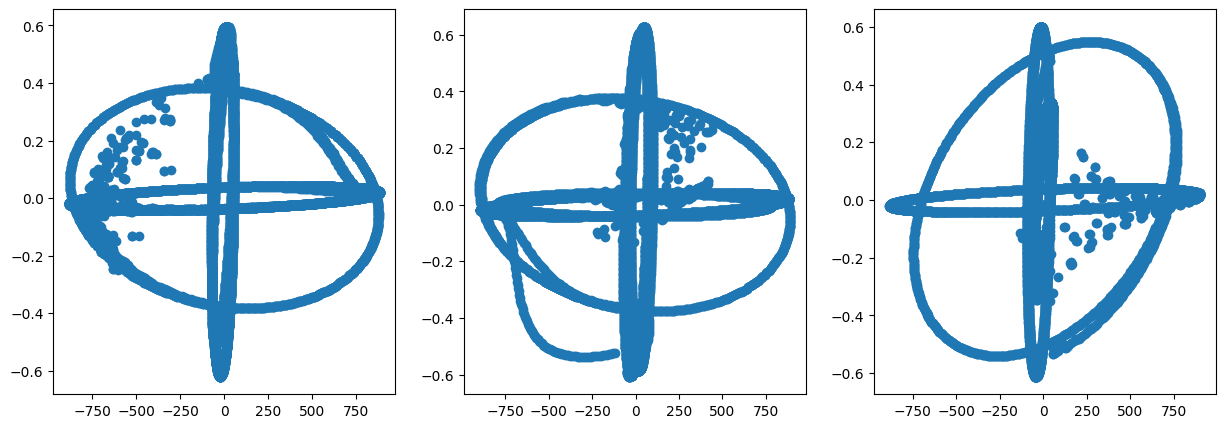

In [44]:
fig,(ax1,ax2,ax3) =plt.subplots(1,3,figsize=(15,5))
colors = {0 :'blue', 1:'red'}
ax1.scatter(dfc['Ia'], dfc['Va'])
ax2.scatter(dfc['Ib'], dfc['Vb'])
ax3.scatter(dfc['Ic'], dfc['Vc'])
plt.show()

In [45]:
dfc=dfc.sample(frac=1,axis=0,random_state=42).reset_index(drop=True)
columns = ['G', 'C','B','A']

dfc.loc[dfc['G']==1, 'G'] =8
dfc.loc[dfc['C']==1, 'C'] =4
dfc.loc[dfc['B']==1, 'B'] =2
dfc.loc[dfc['A']==1, 'A'] =1

dfc['F']=dfc[columns].sum(axis =1)
dfc.drop(columns, axis=1, inplace=True)
dfc['F'].value_counts()

F
0     2365
11    1134
15    1133
9     1129
7     1096
6     1004
Name: count, dtype: int64

Based on the analysis, there are 6 labels for the power system faults. which are stated below : 

- no fault (0)
- fault at G, B, A (11)
- fault @ all (15)
- fault at G, A (9)
- fault at C,B,A (7)
- fault at C, B (6)

In [46]:
X = dfc.iloc[:,0:6].values
y=dfc['F'].values

In [47]:
X_train,X_test,y_train,y_test =train_test_split(X,y, test_size =0.3, shuffle=True, random_state=42)
scores2 = []
models2 =['RF','Ada', 'Gradient']

### RANDOM FOREST

In [48]:
forest = RandomForestClassifier(random_state=42)
forest.fit(X_train,y_train)
forest.score(X_test,y_test)

0.864349300551081

In [49]:
params ={'criterion':['gini','entropy','log_loss'],
         'max_depth' : [3,5,7,9,12],
         'min_samples_split' : [2,3,4,5,6,7,8,9]}

kf = KFold(n_splits =5, shuffle =True , random_state =42)
forest = RandomForestClassifier()
rf_clf = RandomizedSearchCV(forest, param_distributions =params, cv=kf, n_iter=100,verbose=True, random_state=42)
rf_clf.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [3, 5, 7, 9, 12],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9]},
                   random_state=42, verbose=True)

In [50]:
rf_clf.best_params_

{'min_samples_split': 2, 'max_depth': 12, 'criterion': 'entropy'}

In [51]:
score =rf_clf.score(X_test,y_test)
print(score)
scores2.append(score)

0.8321322594319627


<Axes: >

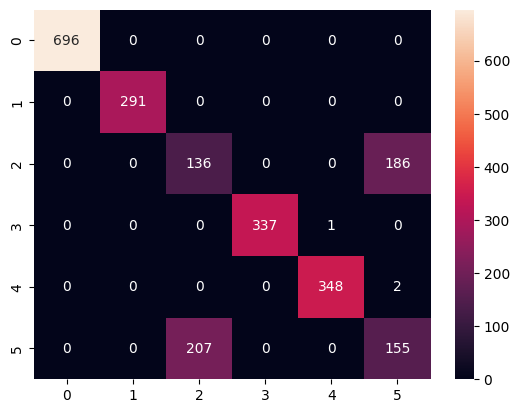

In [52]:
y_pred =rf_clf.predict(X_test)
cm =confusion_matrix(y_pred,y_test)
sns.heatmap(cm, annot=True,fmt='.10g')

In [53]:
y_true =y_test.reshape(-1,1)
y_pred_true =y_pred.reshape(-1,1)
y_test_binarized =label_binarize(y_true,classes =[0,11,15,9,7,6])
y_pred_binarized = label_binarize(y_pred_true,classes =[0,11,15,9,7,6])
print("ROC_AUC_SCORE: ",roc_auc_score(y_test_binarized,y_pred_binarized,multi_class ='ovr'))
print("F1_SCORE: ",f1_score(y_pred,y_test,average='micro'))

ROC_AUC_SCORE:  0.8874250925864161
F1_SCORE:  0.8321322594319627


### ADABOOST

In [54]:
ada= AdaBoostClassifier(algorithm='SAMME',random_state=42)
ada.fit(X_train,y_train)
ada.score(X_test,y_test)

0.7562526494277236

In [55]:
params ={'n_estimators':np.arange(50,101,1),
         'learning_rate' :np.arange(0.01,1.01,0.01),
         'algorithm' :['SAMME']}

kf = KFold(n_splits =5, shuffle =True , random_state =42)
ada= AdaBoostClassifier(algorithm='SAMME')
ada_clf = RandomizedSearchCV(ada, param_distributions =params, cv=kf, n_iter=100, random_state=42)
ada_clf.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=AdaBoostClassifier(algorithm='SAMME'), n_iter=100,
                   param_distributions={'algorithm': ['SAMME'],
                                        'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32...
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ]),
                                        'n_estimators': array([ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100])},
                   random_state=42)

In [56]:
ada_clf.best_params_

{'n_estimators': 87, 'learning_rate': 0.8200000000000001, 'algorithm': 'SAMME'}

In [57]:
score =ada_clf.score(X_test,y_test)
print(score)
scores2.append(score)

0.7660025434506147


<Axes: >

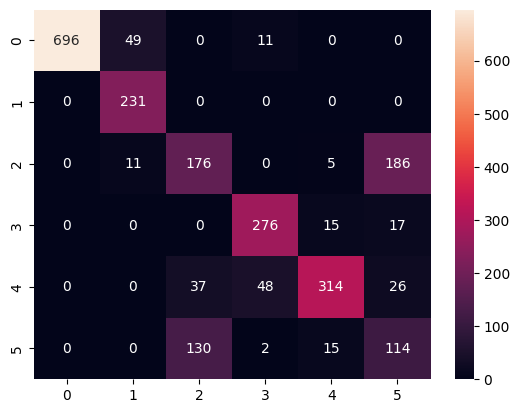

In [58]:
y_pred =ada_clf.predict(X_test)
cm =confusion_matrix(y_pred,y_test)
sns.heatmap(cm, annot=True,fmt='.10g')

In [59]:
print("ROC_AUC_SCORE: ",roc_auc_score(y_test_binarized,y_pred_binarized,multi_class ='ovr'))
print("F1_SCORE: ",f1_score(y_pred,y_test,average='micro'))

ROC_AUC_SCORE:  0.8874250925864161
F1_SCORE:  0.7660025434506147


### GRADIENT BOOSTING 

In [60]:
gb= GradientBoostingClassifier(random_state=42)
gb.fit(X_train,y_train)
gb.score(X_test,y_test)

0.8435777871979653

In [61]:
params ={ 
         'n_estimators':[50,75,125,150,200,250],
         'learning_rate' : np.arange(0.01,1.01,0.01),
         'subsample' :np.arange(0.1,1.1,1.1),
        'max_depth' :[3,5,7,9]}

kf = KFold(n_splits =5, shuffle =True , random_state =42)
gb= GradientBoostingClassifier()
gb_clf = RandomizedSearchCV(gb, param_distributions =params, cv=kf, n_iter=100, random_state=42)
gb_clf.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=GradientBoostingClassifier(), n_iter=100,
                   param_distributions={'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38,...
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ]),
                                        'max_depth': [3, 5, 7, 9],
                                        'n_estimators': [50, 75, 125, 150, 200,
                                                         250],
                                        'subsample': array([0.1])},
                   random_state=42)

In [62]:
gb_clf.best_params_

{'subsample': 0.1, 'n_estimators': 250, 'max_depth': 3, 'learning_rate': 0.08}

In [63]:
score =gb_clf.score(X_test,y_test)
print(score)
scores2.append(score)

0.8486646884272997


<Axes: >

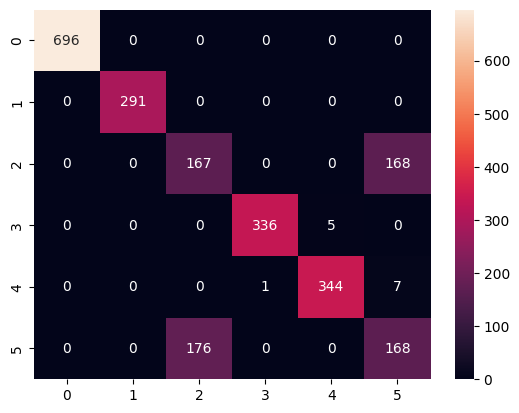

In [64]:
y_pred =gb_clf.predict(X_test)
cm =confusion_matrix(y_pred,y_test)
sns.heatmap(cm, annot=True,fmt='.10g')

In [65]:
print("ROC_AUC_SCORE: ",roc_auc_score(y_test_binarized,y_pred_binarized,multi_class ='ovr'))
print("F1_SCORE: ",f1_score(y_pred,y_test,average='micro'))

ROC_AUC_SCORE:  0.8874250925864161
F1_SCORE:  0.8486646884272997


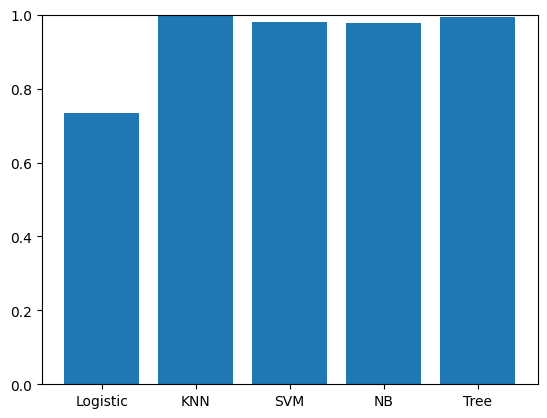

In [66]:
plt.bar(models,scores)
plt.ylim([0,1])
plt.show()

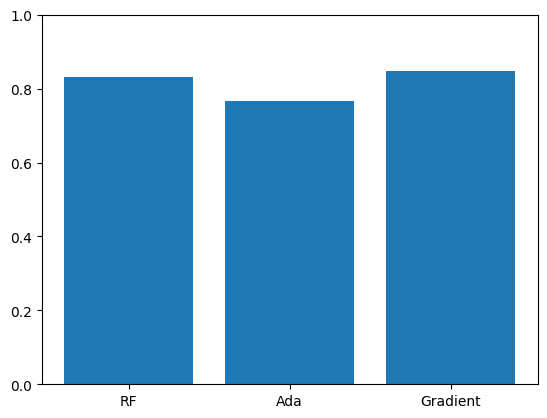

In [67]:
plt.bar(models2,scores2)
plt.ylim([0,1])
plt.show()

Based on the metrics specified (Accuracy Score, Confusion Matrix, ROC AUC Score, F1 Score), KNN will be used for the first model of classfying whether a fault exists, while Gradient Boosting will be used to determined where the fault exists . 

Exporting the model 

In [68]:
with open('knn_model.bin', 'wb') as f_out1:
    pickle.dump(knn_clf,f_out1)

In [69]:
with open('gb_model.bin', 'wb') as f_out2:
    pickle.dump(gb_clf,f_out2)